## 51% attack



In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
plt.style.use('seaborn-deep')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
def scrape_table():
    """
    Scrapes crytpo51 table
    :return: pandas dataframe
    """
    r = requests.get("https://www.crypto51.app/")
    soup = BeautifulSoup(r.text, "lxml")
    data = []
    headers = []
    table = soup.find('table')
    column_names = table.find('thead').find_all('th')
    headers = [ele.text.strip() for ele in column_names]
    rows = table.find('tbody').find_all('tr')
    for row in rows:
        data.append([i.text.strip() for i in row.find_all('td') if i])
    return pd.DataFrame(data, columns=headers)


In [4]:
raw_df = scrape_table()
# raw_df.to_pickle("data/raw_crypto51.p")
# raw_df = pd.read_pickle("data/raw_crypto51.p")
raw_df.head()

,Name,Symbol,Market Cap,Algorithm,Hash Rate,1h Attack Cost,NiceHash-able
0,Bitcoin,BTC,$107.39 B,SHA-256,"38,529 PH/s","$506,855",1%
1,Ethereum,ETH,$47.79 B,Ethash,226 TH/s,"$319,313",4%
2,Bitcoin Cash,BCH,$13.45 B,SHA-256,"5,505 PH/s","$72,418",9%
3,Litecoin,LTC,$5.00 B,Scrypt,310 TH/s,"$54,854",6%
4,Dash,DASH,$1.96 B,X11,3 PH/s,"$18,950",22%


In [5]:
raw_df.tail()

,Name,Symbol,Market Cap,Algorithm,Hash Rate,1h Attack Cost,NiceHash-able
79,SOILcoin,SOIL,"$75,293",Ethash,767 MH/s,$1,"1,085,340%"
80,Phoenixcoin,PXC,-,NeoScrypt,206 MH/s,$6,"24,484%"
81,Pixie Coin,PXC,-,NeoScrypt,206 MH/s,$6,"24,484%"
82,Monero Original,XMO,-,CryptoNight,956 MH/s,"$8,250",64%
83,Rupee,RUP,-,Lyra2REv2,55 GH/s,$50,"13,142%"


In [6]:
def process_raw_market_cap(raw_mcap):
    """
    Converts market cap string into integer, removing symbols.
    """
    mcap = raw_mcap[1:].replace(",", "")
    if len(mcap.split(" ")) == 2:
        num, power = mcap.split(" ")
        if power == "M":
            return int(float(num) * 10**6)
        elif power == "B":
            return int(float(num) * 10**9)
    else:
        return int(mcap)
    
def process_raw_hashrate(raw_hashrate):
    """
    Converts all hash rate strings to ints in MH/s
    """
    num, power = raw_hashrate.replace(',', '').split(' ')
    power = power.split('H/s')[0]
    if power == "M":
        return int(num)
    elif power == "G":
        return int(num) * 10**3
    elif power == "T":
        return int(num) * 10**6
    elif power == "P":
        return int(num) * 10**9

In [7]:
processed_df = raw_df.iloc[:-4,:].copy()
processed_df["Hash Rate"] = processed_df["Hash Rate"].apply(process_raw_hashrate)
processed_df["Market Cap"] = processed_df["Market Cap"].apply(process_raw_market_cap)
processed_df["1h Attack Cost"] = processed_df["1h Attack Cost"].str.replace(",", "").str.replace("$", "").astype(int)
processed_df["NiceHash-able"] = processed_df["NiceHash-able"].str.replace(",", "").str.replace("%", "").astype(float)/100

In [8]:
processed_df.head()

,Name,Symbol,Market Cap,Algorithm,Hash Rate,1h Attack Cost,NiceHash-able
0,Bitcoin,BTC,107390000000,SHA-256,38529000000000,506855,0.01
1,Ethereum,ETH,47790000000,Ethash,226000000,319313,0.04
2,Bitcoin Cash,BCH,13450000000,SHA-256,5505000000000,72418,0.09
3,Litecoin,LTC,5000000000,Scrypt,310000000,54854,0.06
4,Dash,DASH,1960000000,X11,3000000000,18950,0.22


In [9]:
# Log transforms
processed_df["Log Market Cap"] = np.log(processed_df["Market Cap"])
processed_df["Log Attack Cost"] = np.log(1 + processed_df["1h Attack Cost"])
processed_df["Log NiceHash"] = np.log(1 + processed_df["NiceHash-able"])

In [43]:
from scipy.stats import linregress

# Linear fit
print("Linear\n=========")
_, _, r_value_1, p_value_1, _ = linregress(processed_df["Market Cap"],
                                           processed_df["1h Attack Cost"])
print("R^2:", r_value_1**2)
print("p value:", p_value_1)

# Log-log fit
print("Power law\n=========")
slope, intercept, r_value, p_value, _ = linregress(processed_df["Log Market Cap"], 
                                                         processed_df["Log Attack Cost"])
print("R^2:", r_value**2)
print("p value:", p_value)

# Power law expression
multiplier = np.exp(intercept)
print(f"\ncost = {multiplier} * mcap ^ {slope:.2f}")

Linear
R^2: 0.46055333511121543
p value: 4.599451441925646e-12
Power law
R^2: 0.6508727899753779
p value: 1.6643743376882498e-19

 cost = 8.26405175307903e-05 * mcap ^ 0.92


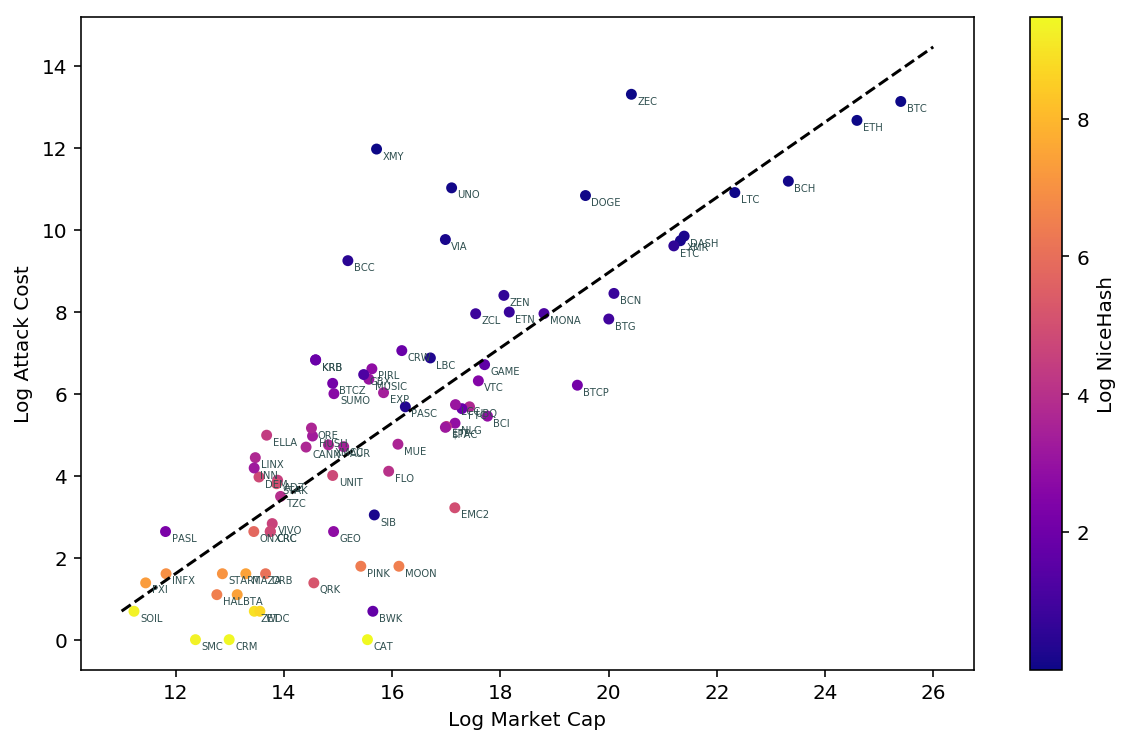

In [50]:
from adjustText import adjust_text

fig, ax = plt.subplots(figsize=(10,6))
processed_df.plot.scatter("Log Market Cap", "Log Attack Cost", c="Log NiceHash", 
                          colormap="plasma", ax=ax)

# Labels
texts = []
def annotate_df(row):  
    texts.append(ax.annotate(row.Symbol, (row["Log Market Cap"], row["Log Attack Cost"]),
                xytext=(3,-5), 
                textcoords='offset points',
                size=5, 
                color='darkslategrey'))
ab = processed_df.apply(annotate_df, axis=1)    
# adjust_text(texts)

# Trendline
x = np.linspace(11, 26)
ax.plot(x, intercept + x * slope, "--k")

# plt.savefig("attackcost-mcap.png", dpi=500)
plt.show()